In [1]:
data='../data/'
rep='ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE142nnn/GSE142439/matrix//GSE142439_series_matrix.txt.gz'
epic_man='https://webdata.illumina.com/downloads/productfiles/methylationEPIC/infinium-methylationepic-v-1-0-b5-manifest-file-csv.zip'
horvath='https://static-content.springer.com/esm/art%3A10.1186%2Fgb-2013-14-10-r115/MediaObjects/13059_2013_3156_MOESM3_ESM.csv'
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
!wget -q -nc {rep} -O {data}\rep.txt.gz
!wget -q -nc {epic_man} -O {data}\epic.csv.zip
!wget -q -nc {horvath} -O {data}\horvath.csv

In [3]:
df=pd.read_csv(data+'rep.txt.gz',sep='\t',skiprows=71,index_col=0) # methylation data starts from line 71
df=df.drop('!series_matrix_table_end')
meta=pd.read_csv(data+'rep.txt.gz',sep='\t',skiprows=40,index_col=0,nrows=3) # meta data starts from line 40
meta.columns=df.columns
meta.index=['age','cell','treatment']
meta=meta.T
meta['age']=meta.age.str.strip('age: ')
meta['cell']=meta.cell.str.strip('cell type: ')
meta['treatment']=meta.treatment.str.strip('treatmentstatus: ')
meta['t']=meta.treatment.apply(lambda x: 1 if x=='Normal' else 0)
meta['cell']=meta.cell.apply(lambda x: 'skin' if x=='skin fibroblasts' else 'vein')
meta.T

,GSM4227385,GSM4227386,GSM4227387,GSM4227388,GSM4227389,GSM4227390,GSM4227391,GSM4227392,GSM4227393,GSM4227394,GSM4227395,GSM4227396,GSM4227397,GSM4227398,GSM4227399,GSM4227400
age,61,61,61,61,69,69,67,67,48,48,47,47,49,49,49,49
cell,skin,skin,skin,skin,skin,skin,skin,skin,vein,vein,vein,vein,vein,vein,vein,vein
treatment,Normal,Treated,Normal,Treated,Normal,Treated,Normal,Treated,Normal,Treated,Normal,Treated,Normal,Treated,Normal,Treated
t,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0


In [4]:
for tissue in ['skin','vein']:
    df[tissue+'_normal']=df[meta[(meta.cell==tissue)&(meta.treatment=='Normal')].index].mean(1)
    df[tissue+'_treated']=df[meta[(meta.cell==tissue)&(meta.treatment=='Treated')].index].mean(1)
    df[tissue+'_dif']=df[tissue+'_normal']-df[tissue+'_treated']
df.head(1)

,GSM4227385,GSM4227386,GSM4227387,GSM4227388,GSM4227389,GSM4227390,GSM4227391,GSM4227392,GSM4227393,GSM4227394,...,GSM4227397,GSM4227398,GSM4227399,GSM4227400,skin_normal,skin_treated,skin_dif,vein_normal,vein_treated,vein_dif
ID_REF,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.192582,0.22964,0.084506,0.102028,0.202294,0.170894,0.185225,0.229188,0.19241,0.152512,...,0.358765,0.366739,0.446669,0.433033,0.166152,0.182937,-0.016786,0.451154,0.454321,-0.003167


<AxesSubplot:>

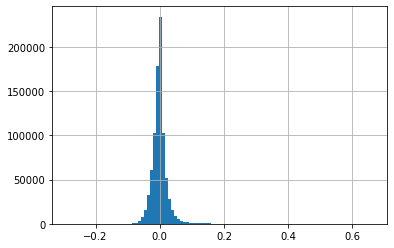

In [5]:
df.skin_dif.hist(bins=100)

In [6]:
epic=pd.read_csv(data+'epic.csv.zip',skiprows=7,index_col=0) # data starts from line 7
epic['Relation_to_UCSC_CpG_Island']=epic.Relation_to_UCSC_CpG_Island.fillna('Open Sea')
epic.shape

/Users/mahdimoqri/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2,4,42,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(866554, 51)

In [7]:
df=df.merge(epic,left_index=True,right_index=True)

In [8]:
dg=df[np.abs(df.skin_dif)>.1]

Text(0, 0.5, 'Treatment effect (treated - normal) ')

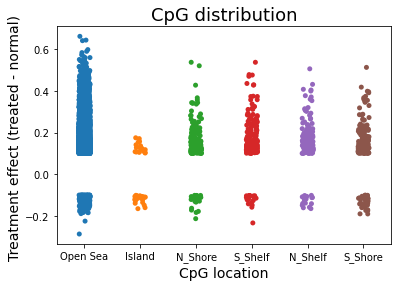

In [9]:
sns.stripplot(data=dg,x='Relation_to_UCSC_CpG_Island',y='skin_dif')
plt.title('CpG distribution', fontsize=18)
plt.xlabel('CpG location', fontsize=14)
plt.ylabel('Treatment effect (treated - normal) ', fontsize=14)

/Users/mahdimoqri/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Treatment effect (treated - normal) ')

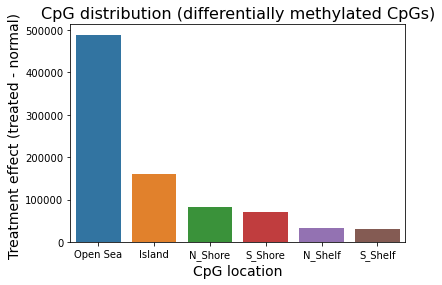

In [10]:
epic_count=epic['Relation_to_UCSC_CpG_Island'].value_counts()
sns.barplot(epic_count.index,epic_count.values)
plt.title('CpG distribution (differentially methylated CpGs)', fontsize=16)
plt.xlabel('CpG location', fontsize=14)
plt.ylabel('Treatment effect (treated - normal) ', fontsize=14)

/Users/mahdimoqri/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Treatment effect (treated - normal) ')

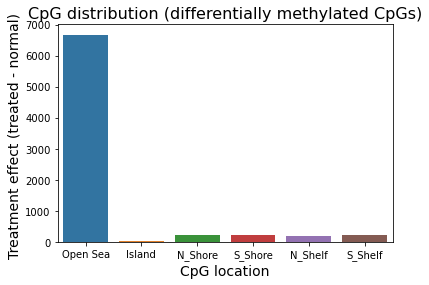

In [11]:
dg_count=dg['Relation_to_UCSC_CpG_Island'].value_counts()
order=['Open Sea', 'Island', 'N_Shore', 'S_Shore', 'N_Shelf', 'S_Shelf']
sns.barplot(order,dg_count.loc[order].values)
plt.title('CpG distribution (differentially methylated CpGs)', fontsize=16)
plt.xlabel('CpG location', fontsize=14)
plt.ylabel('Treatment effect (treated - normal) ', fontsize=14)

In [12]:
horv=pd.read_csv(data+'horvath.csv',index_col=0,skiprows=2)
horv=horv.merge(df[['skin_dif','vein_dif']],left_index=True,right_index=True)
horv['skin_effect']=(horv.CoefficientTraining*horv.skin_dif)*21
horv['vein_effect']=(horv.CoefficientTraining*horv.vein_dif)*21

/Users/mahdimoqri/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Years')

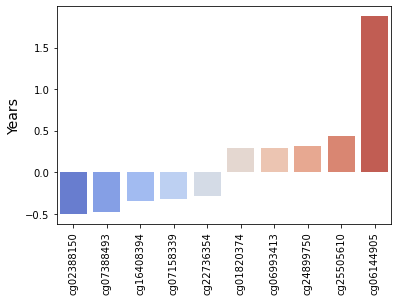

In [13]:
skin=pd.concat([horv.skin_effect.sort_values()[:5],horv.skin_effect.sort_values()[-5:]])
sns.barplot(skin.index,skin.values,palette=("coolwarm"))
plt.xticks(rotation=90);
plt.ylabel('Years', fontsize=14)

/Users/mahdimoqri/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Years')

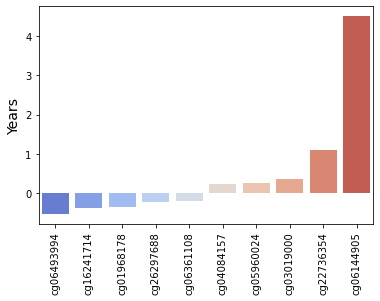

In [14]:
vein=pd.concat([horv.vein_effect.sort_values()[:5],horv.vein_effect.sort_values()[-5:]])
sns.barplot(vein.index,vein.values,palette=("coolwarm"))
plt.xticks(rotation=90);
plt.ylabel('Years', fontsize=14)

In [15]:
topcg=df.loc[horv.sort_values('vein_effect').index[-1]][['CHR','MAPINFO']]
topcg=df[(df.CHR=='17')&(df.MAPINFO>=topcg.MAPINFO)&(df.MAPINFO<topcg.MAPINFO+400)].sort_values("MAPINFO")[['skin_dif','vein_dif']]
topcg

,skin_dif,vein_dif
cg06144905,0.149459,0.358302
cg02463253,0.032011,0.012339
cg00016913,0.178758,0.057542
cg22968401,0.134953,0.014891
cg17751776,0.016066,0.002674


Text(0, 0.5, 'Methylation')

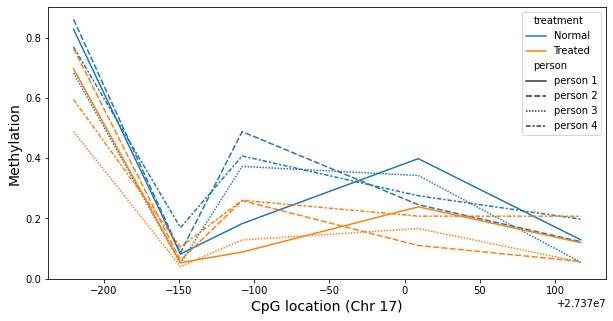

In [16]:
PIPOX=df.loc[topcg.index].T.merge(meta[meta.cell=='skin'][['treatment']],left_index=True,right_index=True)
PIPOX.columns=['mapinfo_'+ str(b) for b in df.loc[topcg.index].MAPINFO.astype(int).values]+['treatment']
PIPOX['person']=['person 1','person 1','person 2','person 2','person 3','person 3','person 4','person 4']
PIPOX['id']=PIPOX.reset_index().index
p=pd.wide_to_long(PIPOX,'mapinfo_','id','i')
p['CpG']=p.index.get_level_values(1)
p['cg']=p['mapinfo_'].astype(float)
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=p,x='CpG',y='cg',style='person',hue='treatment')
plt.xlabel('CpG location (Chr 17)', fontsize=14)
plt.ylabel('Methylation', fontsize=14)


Text(0, 0.5, 'Methylation')

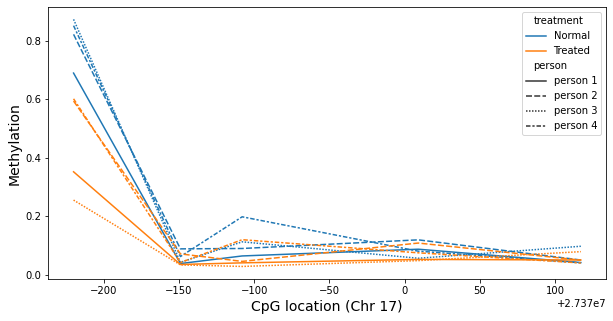

In [17]:
PIPOX=df.loc[topcg.index].T.merge(meta[meta.cell=='vein'][['treatment']],left_index=True,right_index=True)
PIPOX.columns=['mapinfo_'+ str(b) for b in df.loc[topcg.index].MAPINFO.astype(int).values]+['treatment']
PIPOX['person']=['person 1','person 1','person 2','person 2','person 3','person 3','person 4','person 4']
PIPOX['id']=PIPOX.reset_index().index
p=pd.wide_to_long(PIPOX,'mapinfo_','id','i')
p['CpG']=p.index.get_level_values(1)
p['cg']=p['mapinfo_'].astype(float)
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=p,x='CpG',y='cg',style='person',hue='treatment')
plt.xlabel('CpG location (Chr 17)', fontsize=14)
plt.ylabel('Methylation', fontsize=14)